<a href="https://colab.research.google.com/github/khoji-code/Data-Analysis/blob/main/Socio_Economic_Factors_for_Income_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Socio-Economic Factors for Income Prediction

### **Project Overview**

* **Goal:** To build a machine learning model that accurately predicts whether an individual's income is above or below $50,000 per year.
* **Dataset:** Utilizes the "Adult" dataset from the UCI Machine Learning Repository, which contains demographic and socio-economic information.
* **Methodology:** The project involves a comprehensive exploratory data analysis (EDA) to visualize relationships between various features and income levels. An XGBoost classification model is then trained and evaluated using a robust preprocessing pipeline.
* **Key Insights:** The analysis reveals that factors such as age, education level, work class, and capital gains are significant predictors of an individual's income bracket.

***

### **Purpose**

* **Identify Key Factors:** To determine the most influential demographic and socio-economic factors that contribute to an individual's income level.
* **Develop a Predictive Model:** To create an accurate and reliable model for classifying individuals into different income categories, which can be used for socio-economic analysis and targeted policy-making.
* **Provide Actionable Insights:** To offer data-driven insights that can help organizations and policymakers understand the dynamics of income disparity and develop strategies to address it.

## Dataset:
https://archive.ics.uci.edu/dataset/2/adult

## IMPORT LIBRARIES

In [2]:
# Installing XGBOOST
# !pip install -q xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import xgboost as xgb
import warnings

# Ignore warnings for a cleaner output.
warnings.filterwarnings('ignore')
print("Libraries imported successfully.")


Libraries imported successfully.


## LOAD AND PREPARE DATA

In [4]:
# column names based on the 'adult.names' file
# data files do not contain headers
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]

# Load the training and test data
# No header - define '?' as a missing value
try:
    train_df = pd.read_csv('/content/drive/MyDrive/Adult/adult.data', sep=', ', header=None, names=column_names, na_values='?', engine='python')
    test_df = pd.read_csv('/content/drive/MyDrive/Adult/adult.test', sep=', ', header=None, names=column_names, na_values='?', engine='python', skiprows=1)
    print("Training and test data loaded successfully.")
    print("Train shape:", train_df.shape)
    print("Test shape:", test_df.shape)
except FileNotFoundError as e:
    print(f"Error loading data files: {e}")
    print("Please ensure 'adult.data' and 'adult.test' are uploaded to your Colab environment.")
    exit()

Training and test data loaded successfully.
Train shape: (32561, 15)
Test shape: (16281, 15)


### Data Cleaning

In [5]:
test_df['income'] = test_df['income'].str.replace(r'\.', '', regex=True)

# Map the income categories to binary values (0 and 1) for modeling.
income_map = {'<=50K': 0, '>50K': 1}
train_df['income'] = train_df['income'].map(income_map)
test_df['income'] = test_df['income'].map(income_map)

print("\nData cleaned and target variable encoded.")



Data cleaned and target variable encoded.


## EXPLORATORY DATA ANALYSIS (EDA)

### Age Distribution Ridge Plot

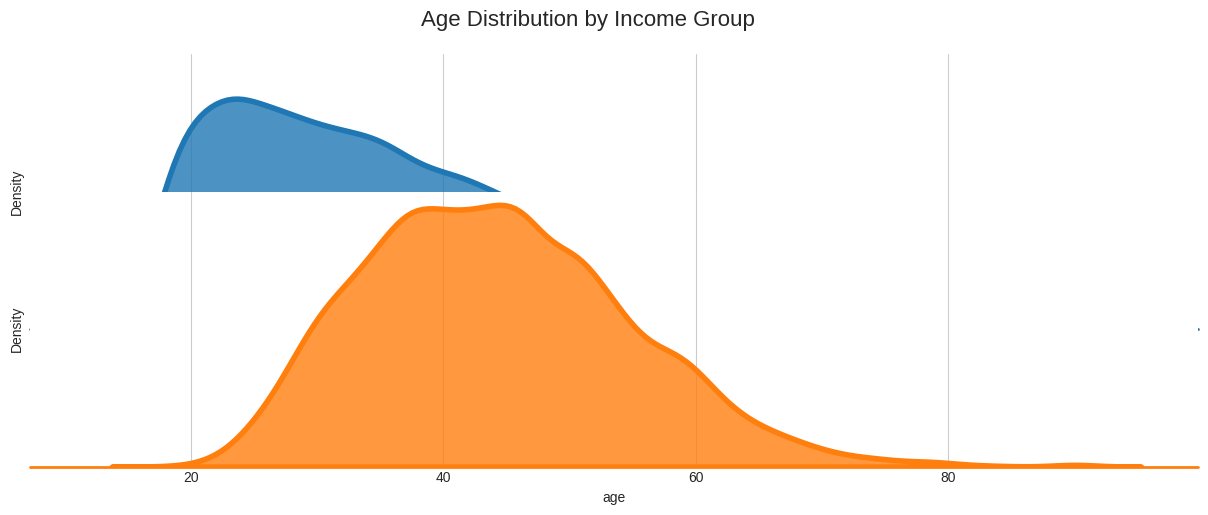

In [6]:
plt.style.use('seaborn-v0_8-whitegrid')
g = sns.FacetGrid(train_df, row="income", hue="income", aspect=5, height=2.5)
g.map(sns.kdeplot, "age", shade=True, alpha=0.8, lw=4)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.suptitle('Age Distribution by Income Group', y=1.02, fontsize=16)
plt.show()

### Income by Education and Workclass Heatmap

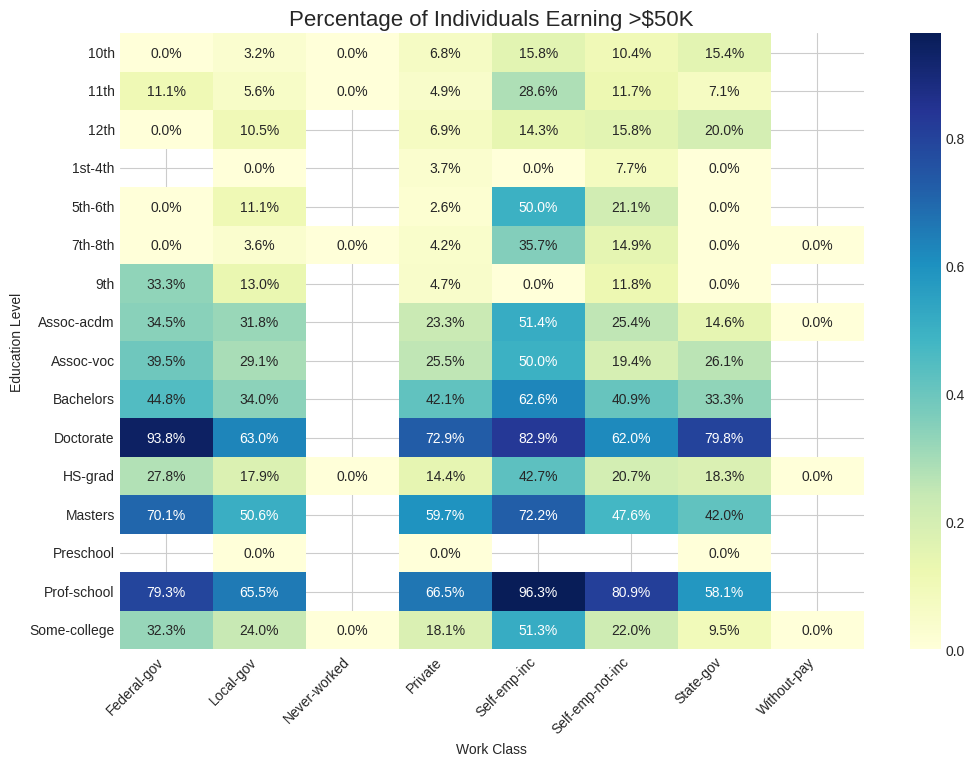

In [7]:
pivot_table = train_df.pivot_table(values='income', index='education', columns='workclass', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".1%", cmap='YlGnBu')
plt.title('Percentage of Individuals Earning >$50K', fontsize=16)
plt.xlabel('Work Class')
plt.ylabel('Education Level')
plt.xticks(rotation=45, ha='right')
plt.show()

### Capital Gains Boxen Plot

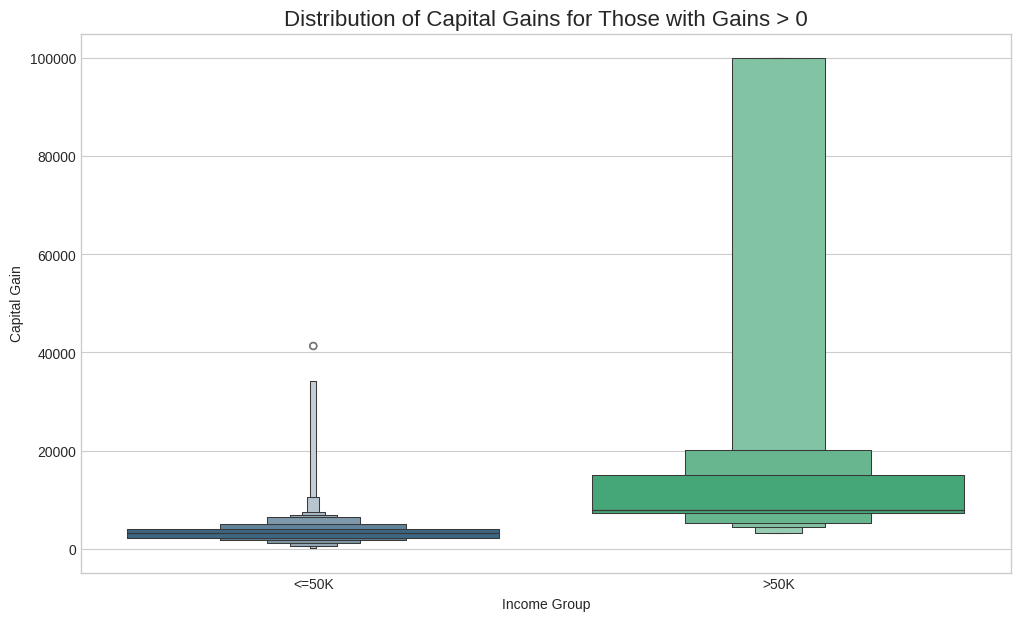

In [8]:
plt.figure(figsize=(12, 7))
# We filter out the zero values to get a more meaningful plot of actual gains.
sns.boxenplot(x='income', y='capital-gain', data=train_df[train_df['capital-gain'] > 0], palette='viridis')
plt.title('Distribution of Capital Gains for Those with Gains > 0', fontsize=16)
plt.xlabel('Income Group')
plt.ylabel('Capital Gain')
plt.xticks(ticks=[0, 1], labels=['<=50K', '>50K'])
plt.show()

## PREPROCESSING AND MODEL PIPELINE

In [9]:
# --- Separate Features and Target ---
X_train = train_df.drop('income', axis=1)
y_train = train_df['income']
X_test = test_df.drop('income', axis=1)
y_test = test_df['income']

# --- Identify Column Types ---
numerical_cols = X_train.select_dtypes(include=np.number).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Create Preprocessing Pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Median is robust to outliers
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Use mode for categorical
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine Pipelines with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough' # Keep any other columns (though there are none here)
)

# Create the Full Model Pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42))
])

print("Pipeline created successfully.")

Pipeline created successfully.


## MODEL TRAINING AND EVALUATION


--- Model Evaluation ---
Accuracy: 0.8729
ROC AUC Score: 0.9262

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.90      0.94      0.92     12435
        >50K       0.77      0.66      0.71      3846

    accuracy                           0.87     16281
   macro avg       0.83      0.80      0.81     16281
weighted avg       0.87      0.87      0.87     16281



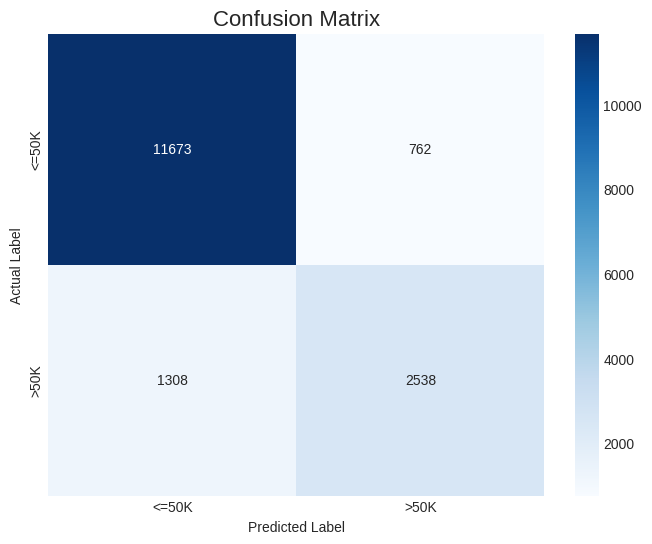

In [10]:
# Fit the Model
model_pipeline.fit(X_train, y_train)

# Make Predictions
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

# Evaluate Performance
print("\n--- Model Evaluation ---")
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['<=50K', '>50K']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['<=50K', '>50K'],
            yticklabels=['<=50K', '>50K'])
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()